A template for plotting the data from a single TDTR-measurement.


In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.data import beam, dataframe

#If the machine you are running the notebook on is incompatible with CUDA gpu computation, simply change this to import bidirectional
from src.analysis import bidirectional_gpu as bidirectional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize
plt.rcParams.update({'font.size' : 12})

import warnings
warnings.filterwarnings('ignore')

If running the notebook on your personal workstation, change the path to files to that of your local data directory

In [ ]:
path_to_files = r'../'

## Beam characterization

Finding the radii of the pump and probe beams, as well as plotting the intensities

(np.int64(1387), np.int64(2616))


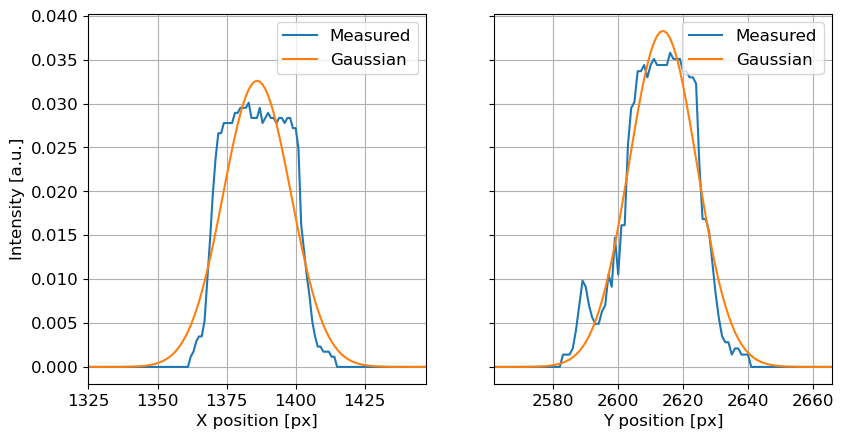

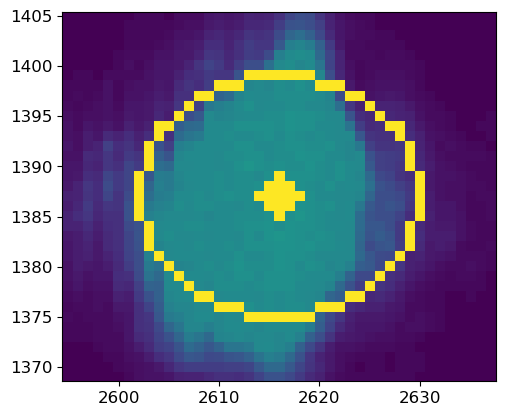

X-axis 1/e2 radius in um: 13.5
Y-axis 1/e2 radius in um: 11.5
Ellipticity: 0.524 (oblate)

Average 1/e2 radius (X radius + Y radius / 2): 12.5
(np.int64(1393), np.int64(2600))


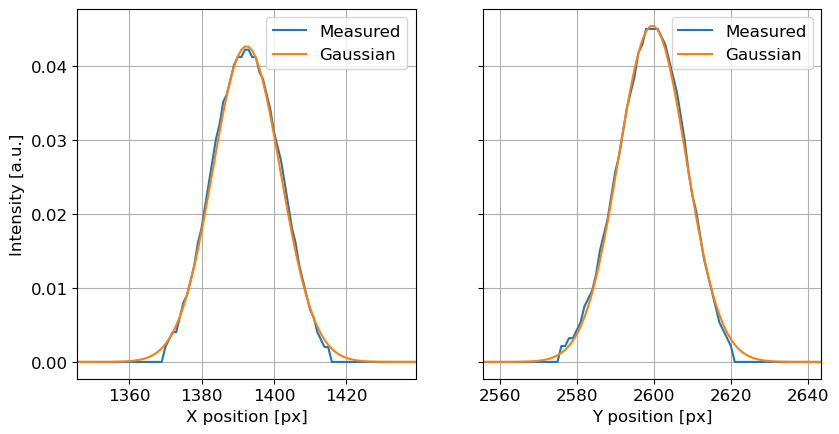

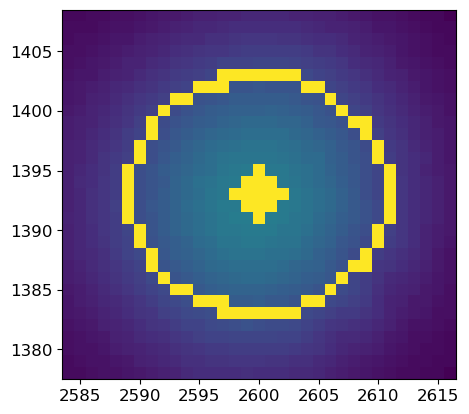

X-axis 1/e2 radius in um: 10.3
Y-axis 1/e2 radius in um: 9.7
Ellipticity: 0.344 (oblate)

Average 1/e2 radius (X radius + Y radius / 2): 10.0
Pump beam radius: 12.5 µm
Probe beam radius: 10.0 µm


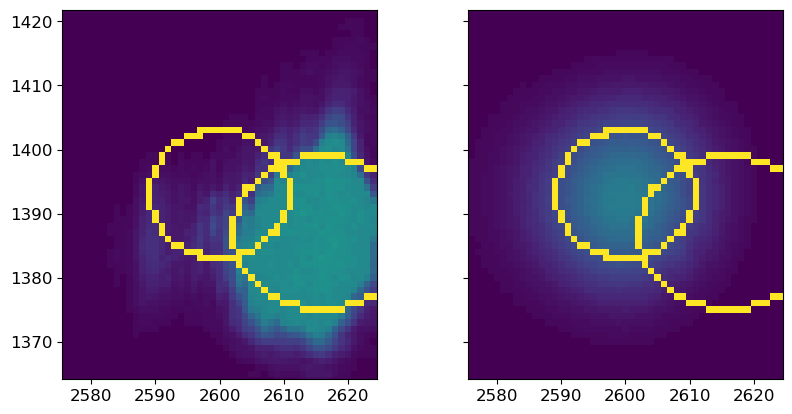

In [ ]:
r_pump, r_probe = beam.characterize_beam(
    red_beam  = path_to_files + r'beam/2025_06_19/probe.tif',
    blue_beam = path_to_files + r'beam/2025_06_19/pump.tif',
    plot = True, verbose = True, use_center = True
)

print('Pump beam radius: %.1f µm' % (r_pump * 1e6))
print('Probe beam radius: %.1f µm' % (r_probe * 1e6))

## Measurement results and picosecond acoustics

Data was shifted by -0.0 degrees
Phase uncertainties (del phase): 0.18 degrees
SNR 35.5 dB


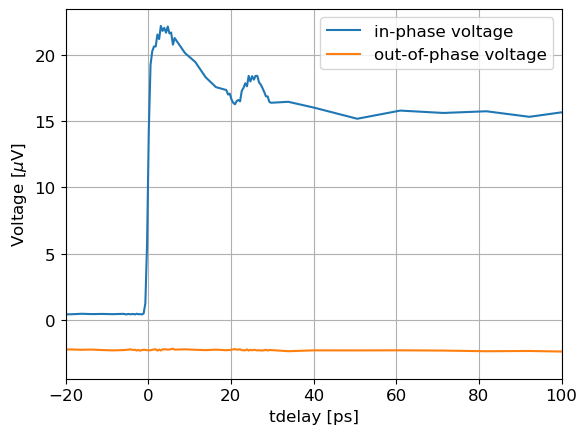

In [ ]:
frequency = 6000e3
data = dataframe.Measurement(
     path_to_files + r"data/raw/AlN_M3-0953_S1@6000kHz_190625_142844.mat"
)

# Finding the t_d=0 position from the midpoint of the rising edge of the signal
t0_shift = data.set_t0()

#Adding a constant phase shift so that V_out is constant around t_d=0
data_shift = data.auto_phase_shift()

#Plotting the measurement data in the given time delay region
data_shift.plot(-20e-12, 100e-12)

print('Data was shifted by %.1f degrees' % data.phase_sol)
print('Phase uncertainties (del phase): %.2f degrees' % data.del_phase)
SNR = data_shift.out_phase_statistics(plot = False, verbose = True)

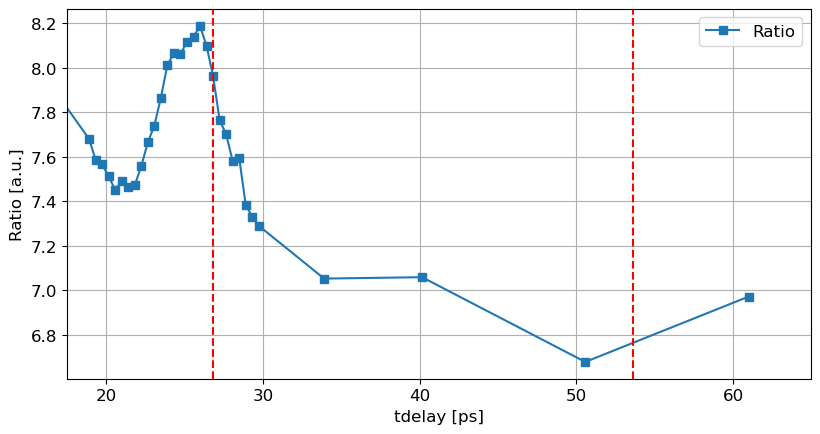

In [ ]:
#Finding the thickness of the aluminium transducer based on picosecond acoustics, default is 80
h_Al = data_shift.picosecond_acoustics(h = 86e-9, use_ratio = True, plot = True) * 1e9
#h_Al = 80

In [ ]:
#Thickness of the sample
sample_thickness = 287

In [ ]:
SystemParameters = bidirectional.SysParam(
    #Pump and probe radii, found from the beam characterization.
    r_pump  = r_pump,
    r_probe = r_probe,

    #Pump and probe intensities, default is 15 mW and 5 mW
    P_pump  = 15e-3,
    P_probe = 5e-3
)

SampleParameters = bidirectional.DutParam(
    #Initial guesses for the conductivities of the layers
    Lambda  = np.array([237, 0.15, 250, 0.1, 140]),
    #Layer lables
    Label   = ['Al', 'Al/AlN', 'AlN', 'AlN/Si', 'Si'],
    #If true, layer of material, if false, interface between two layers
    Layer   = [True, False, True, False, True],
    #Heat capacities of the layers
    C       = np.array([2.43, 0.1, 2.7, 0.1, 1.6]) * 1e6,
    #Thicknesses of the layers
    h       = np.array([h_Al, 1, sample_thickness, 1, 1e6]) * 1e-9,
)

Bidirectional = bidirectional.Bidirectional(SystemParameters)
Bidirectional.set_parameters(
    i_Lambda    = np.array([1, 2, 3]),
    i_C         = np.array([]),
    i_h         = np.array([]),

    #Time delay interval for bidirectional fitting, make sure the beginning is after the picosecond acoustics for reliable results
    tdelay_min  = 60e-12,
    tdelay_max  = 3000e-12
)

Bidirectional.set_sample_parameters(SampleParameters)
Bidirectional.add_measurement_data(frequency, data_shift)

CPU times: user 404 ms, sys: 85.4 ms, total: 490 ms
Wall time: 514 ms


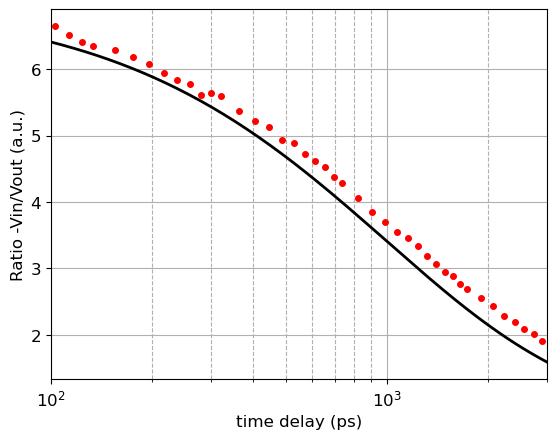

In [8]:
%%time
Bidirectional.plot()

In [9]:
%%time
OptRes = Bidirectional.fit(
    method  = 'Nelder-Mead', 
    bounds  = ((0, np.inf), (10, 1000), (0, np.inf)),
    plot    = False, verbose = True,
    fatol = 0.05, xatol = 0.5
)
# OptRes = Bidirectional.least_squares(
#     bounds = (optimize.Bounds(0.01, 1),
#               optimize.Bounds(0.5, 50), 
#               optimize.Bounds(0.01, 1)),
#     plot   = True, verbose = True
# )

Fitted thermal conductivities (W m^-1 K^-1): 
3. AlN: 289.89
Calculated (lambda / h) thermal conductances (MW m^-2 K^-1): 
2. Al/AlN: 114.20
4. AlN/Si: 102.71
CPU times: user 10.7 s, sys: 3.93 ms, total: 10.7 s
Wall time: 10.7 s


In [10]:
OptRes

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.002282416897542491
             x: [ 1.142e-01  2.899e+02  1.027e-01]
           nit: 32
          nfev: 59
 final_simplex: (array([[ 1.142e-01,  2.899e+02,  1.027e-01],
                       [ 1.142e-01,  2.902e+02,  1.028e-01],
                       [ 1.143e-01,  2.894e+02,  1.029e-01],
                       [ 1.141e-01,  2.899e+02,  1.027e-01]]), array([ 2.282e-03,  2.283e-03,  2.283e-03,  2.283e-03]))

CPU times: user 184 ms, sys: 4.98 ms, total: 189 ms
Wall time: 190 ms


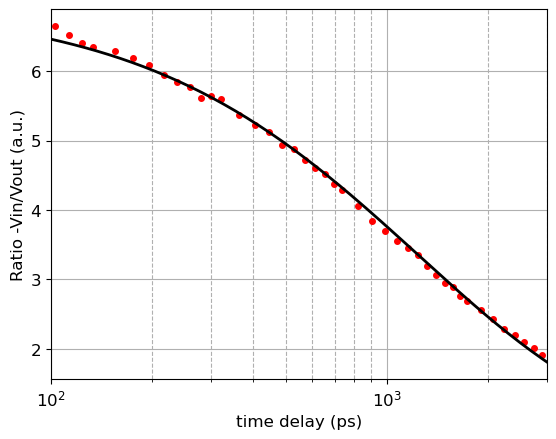

In [11]:
%%time
Bidirectional.plot()

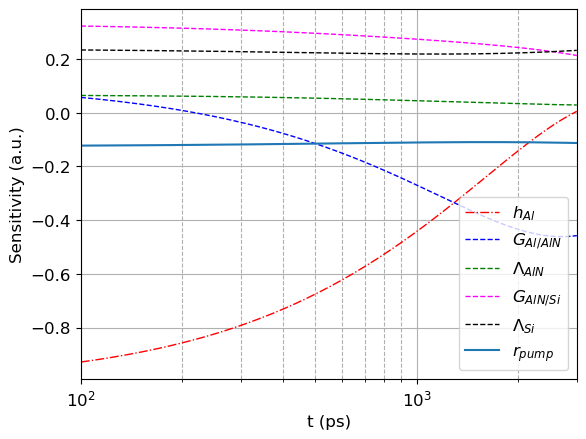

In [12]:
S, Sx = Bidirectional.calculate_sensitivity()
Bidirectional.plot_sensitivity(S, i_C = [], i_h = [0], i_Lambda = [1, 2, 3, 4], 
                               legend_loc = 'lower right')